In [ ]:
from keras.api.applications import EfficientNetB0
from keras import layers
import keras
import tensorflow
import numpy as np
import matplotlib.pyplot as plt

In [49]:
BATCH_SIZE = 32
# B0 - 224x224
# B3 - 300x300
RESOLUTION = 224
NUM_CLASSES = 6

realwaste = keras.utils.image_dataset_from_directory(
    "./data/realwaste",
    labels="inferred",
    label_mode="categorical",
    image_size=(RESOLUTION, RESOLUTION),
    batch_size=None
)

Found 3587 files belonging to 6 classes.


In [41]:
def split(ds, train_split=0.8, val_split=0.1):
    ds_size = len(list(ds.as_numpy_iterator()))
    ds = ds.shuffle(ds.cardinality(), reshuffle_each_iteration=False)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

training_dataset, validation_dataset, test_dataset = split(realwaste)

In [42]:
augmentation_layers = [
    # Lighting variations
    layers.RandomBrightness(factor=(-0.3, 0.3)),
    # Blurring
    layers.GaussianNoise(stddev=0.2),
    # Distortions
    layers.RandomRotation(factor=0.2, fill_mode='nearest'),
    layers.RandomFlip(mode='horizontal'),
    layers.RandomZoom(height_factor=(-0.3, 0.3), width_factor=(-0.3, 0.3)),
    layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode='nearest'),
    # Color variations
    layers.RandomContrast(factor=(0.7, 1.3)),
]

def augment(image):
    for layer in augmentation_layers:
        image = layer(image)
    return image

In [ ]:
def preprocess_augment(image, label):
    image = tensorflow.image.resize(image, (RESOLUTION, RESOLUTION))
    image = augment(image)
    return image, label

def resize(image, label):
    image = tensorflow.image.resize(image, (RESOLUTION, RESOLUTION))
    return image, label

# Preprocess training
training_dataset = training_dataset.map(preprocess_augment, num_parallel_calls=tensorflow.data.AUTOTUNE)
training_dataset = training_dataset.batch(BATCH_SIZE).prefetch(tensorflow.data.AUTOTUNE)

# Preprocess validation & test
validation_dataset = validation_dataset.map(resize, num_parallel_calls=tensorflow.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(BATCH_SIZE).prefetch(tensorflow.data.AUTOTUNE)

test_dataset = test_dataset.map(resize, num_parallel_calls=tensorflow.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tensorflow.data.AUTOTUNE)

In [28]:
inputs = layers.Input(shape=(RESOLUTION, RESOLUTION, 3))
model = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=inputs)

# Freeze layers so we can train the top layers
model.trainable = False

# Recreate top layers
x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3, name="top_dropout")(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

# Compile model
model = keras.Model(inputs, outputs, name="EfficientNet")
optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 59s 552ms/step - accuracy: 0.5040 - loss: 2.0163 - val_accuracy: 0.6425 - val_loss: 1.1663
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 49s 530ms/step - accuracy: 0.6182 - loss: 1.7022 - val_accuracy: 0.7374 - val_loss: 0.9649
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 49s 531ms/step - accuracy: 0.6752 - loss: 1.5130 - val_accuracy: 0.7877 - val_loss: 0.8547
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 49s 531ms/step - accuracy: 0.6837 - loss: 1.4300 - val_accuracy: 0.7849 - val_loss: 0.8044
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 50s 542ms/step - accuracy: 0.6815 - loss: 1.2839 - val_accuracy: 0.7654 - val_loss: 0.8771
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 50s 536ms/step - accuracy: 0.6834 - loss: 1.3232 - val_accuracy: 0.7961 - val_loss: 0.7533
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 49s 533ms/step - accuracy: 0.7005 - loss: 1.1255 - val_accuracy: 0.7709 - val_loss: 0.9347
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 49s 530ms/step - accuracy: 0.7041 - loss: 1.0566 - val_accu

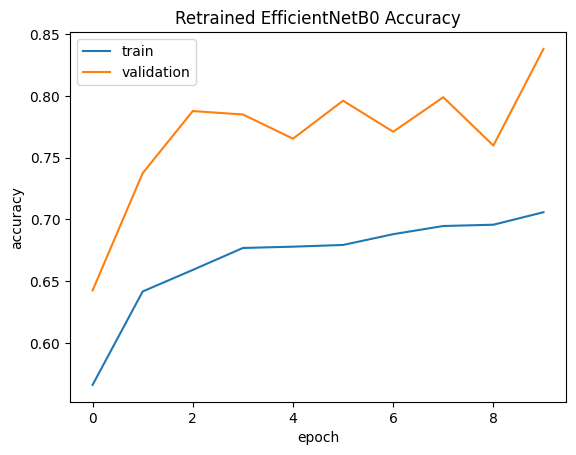

In [29]:
epochs = 10
trained = model.fit(training_dataset, epochs=epochs, validation_data=validation_dataset)

def plot_results(data):
    plt.plot(data.history["accuracy"])
    plt.plot(data.history["val_accuracy"])
    plt.title("Retrained EfficientNetB0 Accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()
    
plot_results(trained)

Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 67s 626ms/step - accuracy: 0.7362 - loss: 0.8432 - val_accuracy: 0.8380 - val_loss: 0.4766
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 56s 602ms/step - accuracy: 0.7620 - loss: 0.7262 - val_accuracy: 0.8603 - val_loss: 0.4167
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 55s 599ms/step - accuracy: 0.7841 - loss: 0.6667 - val_accuracy: 0.8799 - val_loss: 0.3922
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 55s 600ms/step - accuracy: 0.8052 - loss: 0.5665 - val_accuracy: 0.8799 - val_loss: 0.3669
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 56s 603ms/step - accuracy: 0.8008 - loss: 0.6017 - val_accuracy: 0.8687 - val_loss: 0.3168


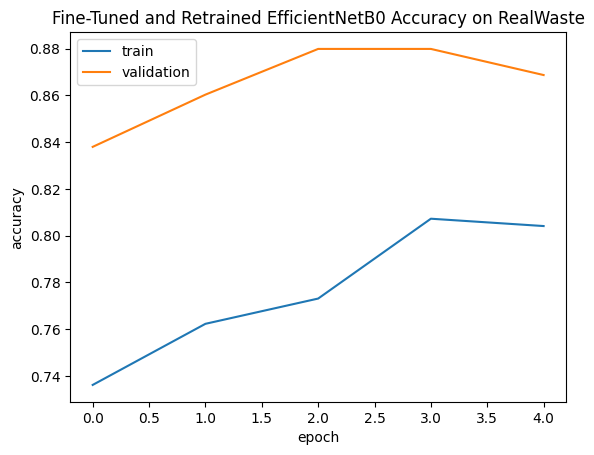

In [30]:
for layer in model.layers[-40:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

epochs = 5
unfrozen_train = model.fit(training_dataset, epochs=epochs, validation_data=validation_dataset, shuffle=True)

def plot_tuned(data):
    plt.plot(data.history["accuracy"])
    plt.plot(data.history["val_accuracy"])
    plt.title("Fine-Tuned and Retrained EfficientNetB0 Accuracy on RealWaste")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

plot_tuned(unfrozen_train)

In [31]:
loss, accuracy = model.evaluate(test_dataset, verbose=1)
print("Test on unseen RealWaste")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 412ms/step - accuracy: 0.9343 - loss: 0.2244
Test on unseen RealWaste
Test Accuracy: 0.9111
Test Loss: 0.2841


In [ ]:
# Evaluate on TrashNet
trashnet = keras.utils.image_dataset_from_directory(
    "./data/trashnet",
    labels="inferred",
    label_mode="categorical",
    image_size=(RESOLUTION, RESOLUTION),
    batch_size=32
)
trash_test_dataset = trashnet.map(resize, num_parallel_calls=tensorflow.data.AUTOTUNE)

loss, accuracy = model.evaluate(trash_test_dataset, verbose=1)
print("Test on TrashNet")
print(f"Test Accuracy: {accuracy:.5f}")
print(f"Test Loss: {loss:.5f}")

Found 2527 files belonging to 6 classes.
79/79 ━━━━━━━━━━━━━━━━━━━━ 35s 436ms/step - accuracy: 0.6120 - loss: 1.8634
Test on TrashNet
Test Accuracy: 0.62881
Test Loss: 1.78859
